In [1]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool
from langsmith import Client, wrappers
from pydantic import BaseModel, Field
from typing_extensions import Annotated
from langgraph.managed.is_last_step import RemainingSteps
from langchain_google_genai import ChatGoogleGenerativeAI
import os, re , ast, tempfile, subprocess, openai
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)
from time import sleep
from langgraph.graph.message import add_messages 

import pandas as pd


load_dotenv()

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


True

In [89]:
df = pd.read_csv('mbpp_san_train.csv', usecols=['task_id','prompt','code','test_list'])
df = df.iloc[0:20]
df.head(20)

,task_id,prompt,code,test_list
0,602,Write a python function to find the first repe...,"def first_repeated_char(str1):\n for index,c ...","['assert first_repeated_char(""abcabc"") == ""a""'..."
1,603,Write a function to get all lucid numbers smal...,def get_ludic(n):\n\tludics = []\n\tfor i in r...,"['assert get_ludic(10) == [1, 2, 3, 5, 7]'\n '..."
2,604,Write a function to reverse words seperated by...,def reverse_words(s):\n return ' '.join...,"['assert reverse_words(""python program"")==(""pr..."
3,605,Write a function to check if the given integer...,def prime_num(num):\n if num >=1:\n for i i...,['assert prime_num(13)==True' 'assert prime_nu...
4,606,Write a function to convert degrees to radians.,import math\ndef radian_degree(degree):\n radi...,['assert radian_degree(90)==1.5707963267948966...
5,607,Write a function to search a string for a rege...,"import re\n\ndef find_literals(text, pattern):...","[""assert find_literals('The quick brown fox ju..."
6,608,Write a python function to find nth bell number.,def bell_Number(n): \n bell = [[0 for i in ...,['assert bell_Number(2) == 2' 'assert bell_Num...
7,610,Write a python function which takes a list and...,"def remove_kth_element(list1, L):\n return ...","['assert remove_kth_element([1,1,2,3,4,4,5,1],..."
8,611,Write a function which given a matrix represen...,"def max_of_nth(test_list, N):\n res = max([su...","['assert max_of_nth([[5, 6, 7], [1, 3, 5], [8,..."
9,612,Write a python function which takes a list of ...,def merge(lst): \n return [list(ele) for e...,"[""assert merge([['x', 'y'], ['a', 'b'], ['m', ..."


In [90]:
def extract_function_names(code: str):
    """
    Return a list of function names found in `code`.
    - Top-level functions and async functions => 'name'
    - Class methods => 'ClassName.method'
    Falls back to a regex search if AST parsing fails.
    """
    if not isinstance(code, str) or not code.strip():
        return []
    names = []
    try:
        tree = ast.parse(code)
        for node in tree.body:
            if isinstance(node, (ast.FunctionDef, ast.AsyncFunctionDef)):
                names.append(node.name)
            elif isinstance(node, ast.ClassDef):
                for item in node.body:
                    if isinstance(item, (ast.FunctionDef, ast.AsyncFunctionDef)):
                        names.append(f"{node.name}.{item.name}")
        return names
    except SyntaxError:
        # fallback: find `def name(` or `async def name(` (simple)
        matches = re.findall(r'^\s*(?:async\s+)?def\s+([A-Za-z_][A-Za-z_0-9]*)\s*\(', code, flags=re.MULTILINE)
        return matches

# Example: apply to your dataframe `df` that has a 'code' column
df['function_names'] = df['code'].fillna('').apply(extract_function_names)
# first (primary) function name (or None)
df['function_name'] = df['function_names'].apply(lambda l: l[0] if l else None)

# Inspect results
print(df[['task_id','function_name']].head(30))

    task_id        function_name
0       602  first_repeated_char
1       603            get_ludic
2       604        reverse_words
3       605            prime_num
4       606        radian_degree
5       607        find_literals
6       608          bell_Number
7       610   remove_kth_element
8       611           max_of_nth
9       612                merge
10      614      cummulative_sum
11      615        average_tuple
12      616         tuple_modulo
13      617            min_Jumps
14      618             div_list
15      619             move_num
16      620       largest_subset
17      622           get_median
18      623             nth_nums
19      624             is_upper


In [5]:
df.drop(columns=['function_names'], inplace=True)
df.head(20)

,task_id,prompt,code,test_list,function_name
0,602,Write a python function to find the first repe...,"def first_repeated_char(str1):\n for index,c ...","['assert first_repeated_char(""abcabc"") == ""a""'...",first_repeated_char
1,603,Write a function to get all lucid numbers smal...,def get_ludic(n):\n\tludics = []\n\tfor i in r...,"['assert get_ludic(10) == [1, 2, 3, 5, 7]'\n '...",get_ludic
2,604,Write a function to reverse words seperated by...,def reverse_words(s):\n return ' '.join...,"['assert reverse_words(""python program"")==(""pr...",reverse_words
3,605,Write a function to check if the given integer...,def prime_num(num):\n if num >=1:\n for i i...,['assert prime_num(13)==True' 'assert prime_nu...,prime_num
4,606,Write a function to convert degrees to radians.,import math\ndef radian_degree(degree):\n radi...,['assert radian_degree(90)==1.5707963267948966...,radian_degree
5,607,Write a function to search a string for a rege...,"import re\n\ndef find_literals(text, pattern):...","[""assert find_literals('The quick brown fox ju...",find_literals
6,608,Write a python function to find nth bell number.,def bell_Number(n): \n bell = [[0 for i in ...,['assert bell_Number(2) == 2' 'assert bell_Num...,bell_Number
7,610,Write a python function which takes a list and...,"def remove_kth_element(list1, L):\n return ...","['assert remove_kth_element([1,1,2,3,4,4,5,1],...",remove_kth_element
8,611,Write a function which given a matrix represen...,"def max_of_nth(test_list, N):\n res = max([su...","['assert max_of_nth([[5, 6, 7], [1, 3, 5], [8,...",max_of_nth
9,612,Write a python function which takes a list of ...,def merge(lst): \n return [list(ele) for e...,"[""assert merge([['x', 'y'], ['a', 'b'], ['m', ...",merge


In [ ]:
def extract_assert_statements(input_string):
    """
    Extract assert statements from a string representation of a list
    """
    if pd.isna(input_string) or input_string == '':
        return []
    
    try:
        # First pass normalization
        normalized = re.sub(r"'\s*\n\s*'", "', '", input_string)
        
        # Second pass: fix missing commas between adjacent quotes
        # This handles cases like "'assert1' 'assert2'" -> "'assert1', 'assert2'"
        normalized = re.sub(r"'(\s*)'", r"',\1'", normalized)
        
        #print(f"Normalized input: {normalized}")
        parsed = ast.parse(normalized, mode='eval')
        return [element.value for element in parsed.body.elts 
                if isinstance(element, ast.Constant) and isinstance(element.value, str)]
    except Exception as e:
        print(f"AST parsing failed: {e}")
        return extract_assert_statements_fallback(input_string)

def extract_assert_statements_fallback(input_string):
    """
    Robust fallback method that handles various formatting issues
    """
    # Remove outer brackets and quotes
    cleaned = input_string.strip().strip('[]')
    
    # Method 1: Split by the pattern that separates assert statements
    # This handles both comma-separated and space-separated cases
    statements = re.split(r"',\s*'|\'\s+\'", cleaned)
    
    # Clean each statement
    cleaned_statements = []
    for stmt in statements:
        stmt = stmt.strip().strip("'")
        if stmt and stmt.startswith('assert'):
            cleaned_statements.append(stmt)
    
    # Method 2: If the above doesn't capture enough, use direct pattern matching
    if len(cleaned_statements) < 2:  # If we didn't find enough statements
        statements = re.findall(r"assert [^']+", cleaned)
        cleaned_statements = [stmt.strip() for stmt in statements if stmt.strip()]
    
    return cleaned_statements

# Apply the extraction function
df['test_list_extracted'] = df['test_list'].apply(extract_assert_statements)

In [112]:
df[['function_name','test_list_extracted']].head(20)

,function_name,test_list_extracted
0,first_repeated_char,"[assert first_repeated_char(""abcabc"") == ""a"", ..."
1,get_ludic,"[assert get_ludic(10) == [1, 2, 3, 5, 7], asse..."
2,reverse_words,"[assert reverse_words(""python program"")==(""pro..."
3,prime_num,"[assert prime_num(13)==True, assert prime_num(..."
4,radian_degree,"[assert radian_degree(90)==1.5707963267948966,..."
5,find_literals,[assert find_literals('The quick brown fox jum...
6,bell_Number,"[assert bell_Number(2) == 2, assert bell_Numbe..."
7,remove_kth_element,"[assert remove_kth_element([1,1,2,3,4,4,5,1],3..."
8,max_of_nth,"[assert max_of_nth([[5, 6, 7], [1, 3, 5], [8, ..."
9,merge,"[assert merge([['x', 'y'], ['a', 'b'], ['m', '..."


In [92]:
df['test_list'].iloc[3]

"['assert prime_num(13)==True' 'assert prime_num(7)==True'\n 'assert prime_num(-1010)==False']"

In [13]:
class TestCode(BaseModel):
    test_code: str = Field(description="The python code for the test cases to validate given python code.")
    description: str = Field(description="A brief description of what the test cases are validating.")
    how_to_use: str = Field(description="Instructions on how to use the test cases.")

class SolutionCode(BaseModel):
    solution_code: str = Field(description="The solution code for the given python task.")
    description: str = Field(description="A brief description of the solution code.")
    how_to_use: str = Field(description="Instructions on how to use the solution code.")

E0000 00:00:1764061421.628629    5098 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


E0000 00:00:1764061421.628629    5098 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


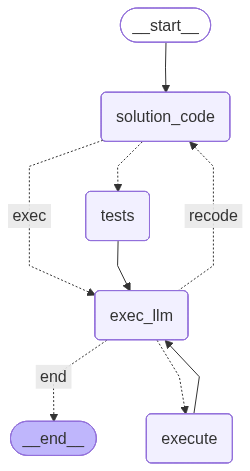

In [14]:
@tool
def execute_code_sub(code: str = Field(description="Code to be executed.")) -> str:
    """Executes the given Python code and returns the output or error message."""
    try:
        # Create a temporary file
        with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
            f.write(code)
            temp_file = f.name
        
        # Execute the file
        result = subprocess.run(
            ['python', temp_file],
            capture_output=True,
            text=True,
            timeout=30
        )
        
        # Clean up
        os.unlink(temp_file)
        
        if result.returncode == 0:
            return "TEST_PASSED"
        else:
            return f"Error: {result.stderr.strip()}"
            
    except subprocess.TimeoutExpired:
        return "Error: Execution timed out"
    except Exception as e:
        return f"Error: {e}"


# MODEL
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)

solution_code_model = llm.with_structured_output(SolutionCode)
test_code_model = llm.with_structured_output(TestCode)


# STATE
class ExecutionState(BaseModel):
    tests_generated: bool = Field(default=False, description="Flag indicating if tests have been generated.")
    test_code: TestCode = None
    test_run: bool = Field(default=False, description="Flag indicating if tests have been run.")
    test_passed: bool = Field(default=False, description="Flag indicating if tests have passed.")
    solution_code: SolutionCode = None
    messages: Annotated[list[AnyMessage], add_messages]
    remaining_steps: RemainingSteps = RemainingSteps()
    


# NODES
def generate_code_tests(state: ExecutionState) -> dict:
    system_message = """
    You are an expert Python programmer. Write tests that can be executed directly without needing function definitions. 
    Use print statements to show test results.
    """
    instruction_message = """
    Write python test code for the following python code. The tests should print "PASSED" if all tests pass or show the specific error if any fail.
    
    Code to test: {solution_code}
    """
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=instruction_message.format(solution_code=state.solution_code.solution_code))
    ]
    
    response = test_code_model.invoke(messages)
    return {
        "test_code": response, 
        "tests_generated": True,
        "messages": [AIMessage(content=f"Generated test code: {response.test_code}")]
    }

def generate_solution_code(state: ExecutionState) -> dict:
    
    if not state.solution_code:
        response = solution_code_model.invoke(state.messages)
        return {"solution_code": response, "messages": [AIMessage(content=f"Generated solution code: {response.solution_code}")]}
    else:
        system_message = """
        You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
        """
        instruction_message = """
        The solution code provided earlier did not pass the tests.Review and fix the solution code to ensure it passes all tests.
        
        Solution Code: {solution_code}  
        
        Execution Results: {results}
        
        Respond with the corrected solution code only.
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(
                solution_code=state.solution_code.solution_code,
                results=state.messages[-1].content,
            ))
        ]
        # print("Invoking ReCode")  # Debug print (commented)
        result = solution_code_model.invoke(messages)
        return {"test_run": False, "solution_code": result, "messages": [AIMessage(content=f"Generated solution code: {result.solution_code}")]}



def exec_llm(state: ExecutionState) -> dict:
    execution_llm = llm.bind_tools([execute_code_sub])
    
    # Build messages for the LLM
    system_message = """
    You are an expert Python code tester. Execute the test code and analyze the results.
    If tests pass, respond with "TEST_PASSED". If tests fail, respond with "TEST_FAILED" and the error details.
    """
    
    # Check if we have tool results to process
    tool_results = []
    # print("Messages in State: ", state.messages)  # Debug print (commented)
    # print(f"State messages -1: {state.messages[-1]}")  # Debug print (commented)
    #for msg in state.messages:
    #    print("Processing message: ", msg)  # Debug print
    #    if isinstance(msg, ToolMessage) and msg.content:
    #        tool_results.append(msg.content)
    if isinstance(state.messages[-1], ToolMessage) and state.messages[-1].content:
        tool_results.append(state.messages[-1].content)
    
    if tool_results:
        # We have execution results to analyze
        instruction_message = """
        Analyze these test execution results and determine if the tests passed or failed:
        
        Test Code: {test_code}
        
        Execution Results: {results}
        
        Respond with "TEST_PASSED" if all tests passed, or "TEST_FAILED" with error details if any tests failed.
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(
                test_code=state.test_code.test_code,
                results="\n".join(tool_results)
            ))
        ]
        result = execution_llm.invoke(messages)
        # print("Analysis LLM Result: ", result.content)  # Debug print (commented)
        return {"messages": [result], "test_run": True, "test_passed": "TEST_PASSED" in result.content}
    else:
        # First call - need to execute the tests
        instruction_message = """
        Execute this test code and return the results: {test_code}
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(test_code=state.test_code.test_code))
        ]
    
        result = execution_llm.invoke(messages)
        # print("Execution LLM Result: ", result)  # Debug print (commented)
        return {"messages": [result]}


def pass_fail(state: ExecutionState) -> str:
    # Look for PASSED/FAILED in recent messages
    #recent_messages = state.messages[-5:]  # Check last 5 messages
    #print(f"TEST Status ---------- {state.test_run}")  # Debug print
    if (state.test_run and state.test_passed) or state.remaining_steps  <= 4:
        #print(f"Tests Passed ? {state.test_passed}")  # Debug print (commented)
        return "end"
    elif not state.test_run:
        return "execute"
    else:
        return "recode"


def skip_if_tests_generated(state: ExecutionState) -> str:
    return "tests" if not state.tests_generated else "exec"


# GRAPH

graph = StateGraph(ExecutionState)
graph.add_node("solution_code", generate_solution_code)
graph.add_node("tests", generate_code_tests)
graph.add_node("exec_llm", exec_llm)
graph.add_node("execute", ToolNode(tools=[execute_code_sub]))

graph.add_edge(START, "solution_code")
graph.add_edge("tests", "exec_llm")
graph.add_edge("execute", "exec_llm")

# Modified conditional edges to properly handle the flow
graph.add_conditional_edges("exec_llm", pass_fail, path_map={ "end": END, "recode": "solution_code", "execute": "execute" })
graph.add_conditional_edges("solution_code", skip_if_tests_generated, path_map={ "tests": "tests", "exec": "exec_llm" })



mbpp_graph = graph.compile()

mbpp_graph



In [15]:
# INSTRUCTIONS
system_message = """
You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
"""
instruction_message = """
Write a solution for the following python task : {task}

Use the following function name for the solution code : {function_name}
"""


## EXECUTION
messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(task=df['prompt'].iloc[0], function_name=df['function_name'])) ]

result = mbpp_graph.invoke({"messages": messages},{"recursion_limit": 20})

In [16]:
result['test_passed']

True

In [17]:
result['solution_code'].solution_code

'\ndef first_repeated_char(s):\n    seen = set()\n    for char in s:\n        if char in seen:\n            return char\n        seen.add(char)\n    return None\n'

In [18]:
result['test_code'].test_code

'def test_first_repeated_char():\n    assert first_repeated_char("abcabc") == "a"\n    assert first_repeated_char("abcdef") == None\n    assert first_repeated_char("aabbcc") == "a"\n    assert first_repeated_char("hello world") == "l"\n    assert first_repeated_char("") == None\n    assert first_repeated_char("a") == None\n    assert first_repeated_char("abacaba") == "a"\n\ntest_first_repeated_char()'

In [ ]:


# Iterate rows and print the function_name and prompt columns
for idx, row in df.iterrows():
    # row is a Series; use .get to avoid KeyError if missing
    #print(row.get('function_name'), row.get('prompt'))
    # If you want to run the graph per row, uncomment and adapt the lines below:
    messages = [SystemMessage(content=system_message), HumanMessage(content=instruction_message.format(task=row.get('prompt'), function_name=row.get('function_name')))]
    result = mbpp_graph.invoke({"messages": messages}, {"recursion_limit": 20})
    print(f"Result for prompt: {row.get('prompt')}\n{result['test_passed']}\nFunction name\n{row.get('function_name')} Solution Code\n{result['solution_code'].solution_code}")  # Debug print
    sleep(20)

Result for prompt: Write a python function to find the first repeated character in a given string.
True
Function name
first_repeated_char Solution Code

def first_repeated_char(s):
    seen = set()
    for char in s:
        if char in seen:
            return char
        seen.add(char)
    return None

Result for prompt: Write a function to get all lucid numbers smaller than or equal to a given integer.
True
Function name
get_ludic Solution Code

def get_ludic(n):
    if n < 1:
        return []
    
    ludic_numbers = [1]
    a = [0] * (n + 1)
    for i in range(3, n + 1, 2):
        if a[i] == 0:
            ludic_numbers.append(i)
            for j in range(i, n + 1, i):
                a[j] = 1
    return ludic_numbers

Result for prompt: Write a function to get all lucid numbers smaller than or equal to a given integer.
True
Function name
get_ludic Solution Code

def get_ludic(n):
    if n < 1:
        return []
    
    ludic_numbers = [1]
    a = [0] * (n + 1)
    for i in ra

In [63]:
for idx, row in test_slice.iterrows():
    print(row.get('function_name'), row.get('prompt'))

bell_Number Write a python function to find nth bell number.
remove_kth_element Write a python function which takes a list and returns a list with the same elements, but the k'th element removed.
max_of_nth Write a function which given a matrix represented as a list of lists returns the max of the n'th column.
merge Write a python function which takes a list of lists, where each sublist has two elements, and returns a list of two lists where the first list has the first element of each sublist and the second one has the second.


In [52]:
df.columns

Index(['task_id', 'prompt', 'code', 'test_list', 'function_names',
       'function_name', 'test_list_extracted'],
      dtype='object')

In [39]:
# create LangSmith client
ls_client = Client()

In [49]:
dataset_name = "CA2 Dataset 1"
#dataset = client.create_dataset(dataset_name)

In [40]:
datasets = ls_client.list_datasets(dataset_name="CA2 Dataset 1")
dataset = next(datasets)
dataset

Dataset(name='CA2 Dataset 1', description=None, data_type=<DataType.kv: 'kv'>, id=UUID('f4591a48-b71e-4718-becb-5c1d224cdfe3'), created_at=datetime.datetime(2025, 11, 24, 13, 19, 32, 844396, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2025, 11, 24, 13, 19, 32, 844396, tzinfo=datetime.timezone.utc), example_count=20, session_count=0, last_session_start_time=None, inputs_schema=None, outputs_schema=None, transformations=None, metadata={'runtime': {'sdk': 'langsmith-py', 'library': 'langsmith', 'runtime': 'python', 'platform': 'Linux-6.14.0-36-generic-x86_64-with-glibc2.39', 'sdk_version': '0.4.35', 'runtime_version': '3.12.3', 'langchain_version': '0.3.27', 'py_implementation': 'CPython', 'langchain_core_version': '0.3.79'}})

In [113]:
examples = []
for idx, row in df.iterrows():
    example = {
        "inputs": {
            "task": row['prompt'],
            "task_id": row['task_id'],
            "function_name": row['function_name']
        },
        "outputs": {
            "ref_code": row['code'],
            "ref_test_list": row['test_list_extracted']
        }
    }
    examples.append(example)



In [114]:
examples

[{'inputs': {'task': 'Write a python function to find the first repeated character in a given string.',
   'task_id': 602,
   'function_name': 'first_repeated_char'},
  'outputs': {'ref_code': 'def first_repeated_char(str1):\n  for index,c in enumerate(str1):\n    if str1[:index+1].count(c) > 1:\n      return c',
   'ref_test_list': ['assert first_repeated_char("abcabc") == "a"',
    'assert first_repeated_char("abc") == None',
    'assert first_repeated_char("123123") == "1"']}},
 {'inputs': {'task': 'Write a function to get all lucid numbers smaller than or equal to a given integer.',
   'task_id': 603,
   'function_name': 'get_ludic'},
  'outputs': {'ref_code': 'def get_ludic(n):\n\tludics = []\n\tfor i in range(1, n + 1):\n\t\tludics.append(i)\n\tindex = 1\n\twhile(index != len(ludics)):\n\t\tfirst_ludic = ludics[index]\n\t\tremove_index = index + first_ludic\n\t\twhile(remove_index < len(ludics)):\n\t\t\tludics.remove(ludics[remove_index])\n\t\t\tremove_index = remove_index + firs

In [115]:
ls_client.create_examples(dataset_id=dataset.id,examples=examples)

{'example_ids': ['ad16e35e-d0b0-4d62-9f4b-aae76cc90d1d',
  '66984c39-60f3-4a4d-858b-c756c47e8045',
  '5545e210-4a7f-4f3e-8bc0-5cdbb288b167',
  '87692fa4-1de7-4dae-8229-fa005b8b251b',
  'dd9489bc-fb08-4d12-84b9-9af00abc4653',
  'eb2f746a-41b0-4ba5-b354-e7c022b22e14',
  '998b97ab-83bf-4b97-ad71-df4c97773cd8',
  'e65ec7a0-f1fe-4f35-919c-212fad5637f6',
  '0766b3f0-6add-4034-96b0-d4f596791709',
  '91d3bc8d-3b6c-40cd-bcee-5deb48e03af6',
  'cd89f3ae-9c81-4ecd-a10a-e8bbccfc257f',
  'bf19807e-8643-4e52-8227-a97a14423330',
  '96b216b6-5977-4220-a1f1-d4fa95d4a224',
  'b2408e18-06a2-4fd3-a263-d81c01b8a258',
  '035fe63a-e963-4bd9-9376-49cbcff1438e',
  '37f34ff6-04c6-48d9-947f-13acb2647926',
  'ae838837-9414-4e1d-8112-61fe9a97d011',
  '9bb1cf90-a51e-4a5d-b430-7cdf6bb2aa90',
  '91f7a88f-3dc2-4770-8090-7cc7038767c6',
  'dbbd3b53-6a7f-455c-98d8-d06fa2aee28b'],
 'count': 20}

In [42]:
ls_client.list_examples(dataset_id=dataset.id)

<generator object Client.list_examples at 0x758d60668fe0>

In [116]:
def test_accuracy(outputs: dict, reference_outputs: dict) -> int:
    """Evaluate the solution code against the reference test code. Returns percentage of reference tests passed"""
    print(f"Outputs keys: {outputs.keys()}")  # Debug
    print(f"Reference outputs keys: {reference_outputs.keys()}")  # Debug
    print(f"Reference outputs: {reference_outputs}")  # Debug
    resp_code = outputs['response']['solution_code'].solution_code
    ref_tests = reference_outputs['ref_test_list']
    total_tests = len(ref_tests)
    if total_tests == 0:
        return 100  # No tests to run, consider as 100% passed
    passed_tests = 0
    for test in ref_tests:
        """run code"""
        #result = execute_code_sub(code=resp_code + "\n" + test)
        result = execute_code_sub.invoke({"code": resp_code + "\n" + test})
        if "TEST_PASSED" in result:
            passed_tests += 1
    accuracy = (passed_tests / total_tests) * 100
    return accuracy

In [120]:
def my_app(task: str, function_name: str):
    # INSTRUCTIONS
    system_message = """
    You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
    """
    instruction_message = """
    Write a solution for the following python task : {task}

    Use the following function name for the solution code : {function_name}
    """


    ## EXECUTION
    messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(task=task, function_name=function_name)) ]

    result = mbpp_graph.invoke({"messages": messages},{"recursion_limit": 20})
    #time.sleep(20)  # To help stop hitting the API quota
    return result

In [121]:
def ls_target(inputs: dict) -> dict:
    return {"response": my_app(inputs['task'], inputs['function_name'])}

In [122]:
ls_client.evaluate(
    ls_target,
    dataset_name,
    evaluators=[test_accuracy],
    experiment_prefix="ca2"
)

View the evaluation results for experiment: 'ca2-58a13575' at:
https://smith.langchain.com/o/964e7404-67a2-4b32-87f1-9ca489d8bbd5/datasets/f4591a48-b71e-4718-becb-5c1d224cdfe3/compare?selectedSessions=39683156-9cb1-4948-9838-946c471b0edd




1it [00:05,  5.26s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def is_upper(string):\n  return (string.upper())', 'ref_test_list': ['assert is_upper("person") =="PERSON"', 'assert is_upper("final") == "FINAL"', 'assert is_upper("Valid") == "VALID"']}


2it [00:10,  4.99s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': "def reverse_words(s):\n        return ' '.join(reversed(s.split()))", 'ref_test_list': ['assert reverse_words("python program")==("program python")', 'assert reverse_words("java language")==("language java")', 'assert reverse_words("indian man")==("man indian")']}


3it [00:15,  4.97s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def first_repeated_char(str1):\n  for index,c in enumerate(str1):\n    if str1[:index+1].count(c) > 1:\n      return c', 'ref_test_list': ['assert first_repeated_char("abcabc") == "a"', 'assert first_repeated_char("abc") == None', 'assert first_repeated_char("123123") == "1"']}


4it [00:27,  7.83s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def average_tuple(nums):\n    result = [sum(x) / len(x) for x in zip(*nums)]\n    return result', 'ref_test_list': ['assert average_tuple(((10, 10, 10, 12), (30, 45, 56, 45), (81, 80, 39, 32), (1, 2, 3, 4)))==[30.5, 34.25, 27.0, 23.25]', 'assert average_tuple(((1, 1, -5), (30, -15, 56), (81, -60, -39), (-10, 2, 3)))== [25.5, -18.0, 3.75]', 'assert average_tuple( ((100, 100, 100, 120), (300, 450, 560, 450), (810, 800, 390, 320), (10, 20, 30, 40)))==[305.0, 342.5, 270.0, 232.5]']}


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 17.557941245s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quot

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def remove_kth_element(list1, L):\n    return  list1[:L-1] + list1[L:]', 'ref_test_list': ['assert remove_kth_element([1,1,2,3,4,4,5,1],3)==[1, 1, 3, 4, 4, 5, 1]', 'assert remove_kth_element([0, 0, 1, 2, 3, 4, 4, 5, 6, 6, 6, 7, 8, 9, 4, 4],4)==[0, 0, 1, 3, 4, 4, 5, 6, 6, 6, 7, 8, 9, 4, 4]', 'assert remove_kth_element([10, 10, 15, 19, 18, 18, 17, 26, 26, 17, 18, 10],5)==[10,10,15,19, 18, 17, 26, 26, 17, 18, 10]']}


6it [01:44, 22.50s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def largest_subset(a):\n\tn = len(a)\n\tdp = [0 for i in range(n)]\n\tdp[n - 1] = 1; \n\tfor i in range(n - 2, -1, -1):\n\t\tmxm = 0;\n\t\tfor j in range(i + 1, n):\n\t\t\tif a[j] % a[i] == 0 or a[i] % a[j] == 0:\n\t\t\t\tmxm = max(mxm, dp[j])\n\t\tdp[i] = 1 + mxm\n\treturn max(dp)', 'ref_test_list': ['assert largest_subset([ 1, 3, 6, 13, 17, 18 ]) == 4', 'assert largest_subset([10, 5, 3, 15, 20]) == 3', 'assert largest_subset([18, 1, 3, 6, 13, 17]) == 4']}


7it [01:52, 17.90s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def max_of_nth(test_list, N):\n  res = max([sub[N] for sub in test_list])\n  return (res) ', 'ref_test_list': ['assert max_of_nth([[5, 6, 7], [1, 3, 5], [8, 9, 19]], 2) == 19', 'assert max_of_nth([[6, 7, 8], [2, 4, 6], [9, 10, 20]], 1) == 10', 'assert max_of_nth([[7, 8, 9], [3, 5, 7], [10, 11, 21]], 1) == 11']}


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 46.683475681s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quot

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def merge(lst):  \n    return [list(ele) for ele in list(zip(*lst))] ', 'ref_test_list': ["assert merge([['x', 'y'], ['a', 'b'], ['m', 'n']]) == [['x', 'a', 'm'], ['y', 'b', 'n']]assert merge([[1, 2], [3, 4], [5, 6], [7, 8]]) == [[1, 3, 5, 7], [2, 4, 6, 8]]assert merge([['x', 'y','z' ], ['a', 'b','c'], ['m', 'n','o']]) == [['x', 'a', 'm'], ['y', 'b', 'n'],['z', 'c','o']]"]}


9it [02:17, 14.32s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def get_median(arr1, arr2, n):\n  i = 0\n  j = 0\n  m1 = -1\n  m2 = -1\n  count = 0\n  while count < n + 1:\n    count += 1\n    if i == n:\n      m1 = m2\n      m2 = arr2[0]\n      break\n    elif j == n:\n      m1 = m2\n      m2 = arr1[0]\n      break\n    if arr1[i] <= arr2[j]:\n      m1 = m2\n      m2 = arr1[i]\n      i += 1\n    else:\n      m1 = m2\n      m2 = arr2[j]\n      j += 1\n  return (m1 + m2)/2', 'ref_test_list': ['assert get_median([1, 12, 15, 26, 38], [2, 13, 17, 30, 45], 5) == 16.0', 'assert get_median([2, 4, 8, 9], [7, 13, 19, 28], 4) == 8.5', 'assert get_median([3, 6, 14, 23, 36, 42], [2, 18, 27, 39, 49, 55], 6) == 25.0']}


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 23.387249406s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quot

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': "def move_num(test_str):\n  res = ''\n  dig = ''\n  for ele in test_str:\n    if ele.isdigit():\n      dig += ele\n    else:\n      res += ele\n  res += dig\n  return (res) ", 'ref_test_list': ["assert move_num('I1love143you55three3000thousand') == 'Iloveyouthreethousand1143553000'assert move_num('Avengers124Assemble') == 'AvengersAssemble124'assert move_num('Its11our12path13to14see15things16do17things') == 'Itsourpathtoseethingsdothings11121314151617'"]}


11it [03:25, 22.77s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'import re\n\ndef find_literals(text, pattern):\n  match = re.search(pattern, text)\n  s = match.start()\n  e = match.end()\n  return (match.re.pattern, s, e)', 'ref_test_list': ["assert find_literals('The quick brown fox jumps over the lazy dog.', 'fox') == ('fox', 16, 19)assert find_literals('Its been a very crazy procedure right', 'crazy') == ('crazy', 16, 21)assert find_literals('Hardest choices required strongest will', 'will') == ('will', 35, 39)"]}


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 16.767151445s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quot

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'import math\ndef radian_degree(degree):\n radian = degree*(math.pi/180)\n return radian', 'ref_test_list': ['assert radian_degree(90)==1.5707963267948966', 'assert radian_degree(60)==1.0471975511965976', 'assert radian_degree(120)==2.0943951023931953']}


13it [04:38, 26.92s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def prime_num(num):\n  if num >=1:\n   for i in range(2, num//2):\n     if (num % i) == 0:\n                return False\n     else:\n                return True\n  else:\n          return False', 'ref_test_list': ['assert prime_num(13)==True', 'assert prime_num(7)==True', 'assert prime_num(-1010)==False']}


14it [04:43, 20.36s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def nth_nums(nums,n):\n nth_nums = list(map(lambda x: x ** n, nums))\n return nth_nums', 'ref_test_list': ['assert nth_nums([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],2)==[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]', 'assert nth_nums([10,20,30],3)==([1000, 8000, 27000])', 'assert nth_nums([12,15],5)==([248832, 759375])']}


15it [04:49, 16.20s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def div_list(nums1,nums2):\n  result = map(lambda x, y: x / y, nums1, nums2)\n  return list(result)', 'ref_test_list': ['assert div_list([4,5,6],[1, 2, 3])==[4.0,2.5,2.0]', 'assert div_list([3,2],[1,4])==[3.0, 0.5]', 'assert div_list([90,120],[50,70])==[1.8, 1.7142857142857142]']}


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 49.892924867s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quot

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def tuple_modulo(test_tup1, test_tup2):\n  res = tuple(ele1 % ele2 for ele1, ele2 in zip(test_tup1, test_tup2)) \n  return (res) ', 'ref_test_list': ['assert tuple_modulo((10, 4, 5, 6), (5, 6, 7, 5)) == (0, 4, 5, 1)', 'assert tuple_modulo((11, 5, 6, 7), (6, 7, 8, 6)) == (5, 5, 6, 1)', 'assert tuple_modulo((12, 6, 7, 8), (7, 8, 9, 7)) == (5, 6, 7, 1)']}


17it [05:22, 15.32s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def cummulative_sum(test_list):\n  res = sum(map(sum, test_list))\n  return (res)', 'ref_test_list': ['assert cummulative_sum([(1, 3), (5, 6, 7), (2, 6)]) == 30', 'assert cummulative_sum([(2, 4), (6, 7, 8), (3, 7)]) == 37', 'assert cummulative_sum([(3, 5), (7, 8, 9), (4, 8)]) == 44']}


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 20.968055321s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quot

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def bell_Number(n): \n    bell = [[0 for i in range(n+1)] for j in range(n+1)] \n    bell[0][0] = 1\n    for i in range(1, n+1):\n        bell[i][0] = bell[i-1][i-1]\n        for j in range(1, i+1): \n            bell[i][j] = bell[i-1][j-1] + bell[i][j-1] \n    return bell[n][0] ', 'ref_test_list': ['assert bell_Number(2) == 2', 'assert bell_Number(3) == 5', 'assert bell_Number(4) == 15']}


19it [06:44, 25.22s/it]

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def get_ludic(n):\n\tludics = []\n\tfor i in range(1, n + 1):\n\t\tludics.append(i)\n\tindex = 1\n\twhile(index != len(ludics)):\n\t\tfirst_ludic = ludics[index]\n\t\tremove_index = index + first_ludic\n\t\twhile(remove_index < len(ludics)):\n\t\t\tludics.remove(ludics[remove_index])\n\t\t\tremove_index = remove_index + first_ludic - 1\n\t\tindex += 1\n\treturn ludics', 'ref_test_list': ['assert get_ludic(10) == [1, 2, 3, 5, 7]', 'assert get_ludic(25) == [1, 2, 3, 5, 7, 11, 13, 17, 23, 25]', 'assert get_ludic(45) == [1, 2, 3, 5, 7, 11, 13, 17, 23, 25, 29, 37, 41, 43]']}


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 48.744126162s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quot

Outputs keys: dict_keys(['response'])
Reference outputs keys: dict_keys(['ref_code', 'ref_test_list'])
Reference outputs: {'ref_code': 'def min_Jumps(steps, d): \n    (a, b) = steps\n    temp = a \n    a = min(a, b) \n    b = max(temp, b) \n    if (d >= b): \n        return (d + b - 1) / b \n    if (d == 0): \n        return 0\n    if (d == a): \n        return 1\n    else:\n        return 2', 'ref_test_list': ['assert min_Jumps((3,4),11)==3.5', 'assert min_Jumps((3,4),0)==0', 'assert min_Jumps((11,14),11)==1']}


20it [07:03, 21.17s/it]


,inputs.task,inputs.task_id,inputs.function_name,outputs.response,error,reference.ref_code,reference.ref_test_list,feedback.test_accuracy,execution_time,example_id,id
0,Write a python function to convert a given str...,624,is_upper,"{'tests_generated': True, 'test_code': test_co...",None,def is_upper(string):\n return (string.upper()),"[assert is_upper(""person"") ==""PERSON"", assert ...",100.000000,5.161459,035fe63a-e963-4bd9-9376-49cbcff1438e,8bb62e8e-23d2-47a1-92ac-c1b8df1c7641
1,Write a function to reverse words seperated by...,604,reverse_words,"{'tests_generated': True, 'test_code': test_co...",None,def reverse_words(s):\n return ' '.join...,"[assert reverse_words(""python program"")==(""pro...",0.000000,4.744592,0766b3f0-6add-4034-96b0-d4f596791709,186ce293-2c58-4251-9afb-fca698ecfb6a
2,Write a python function to find the first repe...,602,first_repeated_char,"{'tests_generated': True, 'test_code': test_co...",None,"def first_repeated_char(str1):\n for index,c ...","[assert first_repeated_char(""abcabc"") == ""a"", ...",100.000000,4.867791,37f34ff6-04c6-48d9-947f-13acb2647926,bb80ea78-7283-4c32-9a10-903d52070a14
3,Write a function which takes a tuple of tuples...,615,average_tuple,"{'tests_generated': True, 'test_code': test_co...",None,def average_tuple(nums):\n result = [sum(x)...,"[assert average_tuple(((10, 10, 10, 12), (30, ...",0.000000,12.109684,5545e210-4a7f-4f3e-8bc0-5cdbb288b167,9366e119-0aab-4f33-be12-e38f6ab1d6c9
4,Write a python function which takes a list and...,610,remove_kth_element,"{'tests_generated': True, 'test_code': test_co...",None,"def remove_kth_element(list1, L):\n return ...","[assert remove_kth_element([1,1,2,3,4,4,5,1],3...",33.333333,69.044142,66984c39-60f3-4a4d-858b-c756c47e8045,d941630d-5176-48d4-92c0-eefcb03e9709
5,Write a function to find the size of the large...,620,largest_subset,"{'tests_generated': True, 'test_code': test_co...",None,def largest_subset(a):\n\tn = len(a)\n\tdp = [...,"[assert largest_subset([ 1, 3, 6, 13, 17, 18 ]...",100.000000,8.010180,87692fa4-1de7-4dae-8229-fa005b8b251b,a50bfc71-4d62-40fe-86e6-539b21a3f3b9
6,Write a function which given a matrix represen...,611,max_of_nth,"{'tests_generated': True, 'test_code': test_co...",None,"def max_of_nth(test_list, N):\n res = max([su...","[assert max_of_nth([[5, 6, 7], [1, 3, 5], [8, ...",100.000000,8.365145,91d3bc8d-3b6c-40cd-bcee-5deb48e03af6,e81c9d32-1e7d-4ec9-a9fd-f7e522fffda2
7,Write a python function which takes a list of ...,612,merge,"{'tests_generated': True, 'test_code': test_co...",None,def merge(lst): \n return [list(ele) for e...,"[assert merge([['x', 'y'], ['a', 'b'], ['m', '...",0.000000,17.853283,91f7a88f-3dc2-4770-8090-7cc7038767c6,e8e2b89e-e432-456b-9b0d-2042412bdb6e
8,Write a function to find the median of two sor...,622,get_median,"{'tests_generated': True, 'test_code': test_co...",None,"def get_median(arr1, arr2, n):\n i = 0\n j =...","[assert get_median([1, 12, 15, 26, 38], [2, 13...",0.000000,6.405778,96b216b6-5977-4220-a1f1-d4fa95d4a224,1b8b4cfa-908c-4cb4-a9d6-d8512fd7582a
9,Write a function to move all the numbers to th...,619,move_num,"{'tests_generated': True, 'test_code': test_co...",None,def move_num(test_str):\n res = ''\n dig = '...,[assert move_num('I1love143you55three3000thous...,0.000000,55.207991,998b97ab-83bf-4b97-ad71-df4c97773cd8,cadc4999-4bfa-40cf-a31e-0f23de4ef093


In [70]:
gen = ls_client.list_examples(dataset_id=dataset.id)

In [71]:
test = next(gen)
test

<class 'langsmith.schemas.Example'>(id=1a20d6d2-cd20-4dc3-96d6-741093293ff7, dataset_id=f4591a48-b71e-4718-becb-5c1d224cdfe3, link='https://smith.langchain.com/o/964e7404-67a2-4b32-87f1-9ca489d8bbd5/datasets/f4591a48-b71e-4718-becb-5c1d224cdfe3/e/1a20d6d2-cd20-4dc3-96d6-741093293ff7')

In [79]:
for example in examples:
    print(example['outputs']['ref_test_list'])

['assert first_repeated_char("abcabc") == "a"', 'assert first_repeated_char("abc") == None', 'assert first_repeated_char("123123") == "1"']
['assert get_ludic(10) == [1, 2, 3, 5, 7]', 'assert get_ludic(25) == [1, 2, 3, 5, 7, 11, 13, 17, 23, 25]', 'assert get_ludic(45) == [1, 2, 3, 5, 7, 11, 13, 17, 23, 25, 29, 37, 41, 43]']
['assert reverse_words("python program")==("program python")', 'assert reverse_words("java language")==("language java")', 'assert reverse_words("indian man")==("man indian")']
['assert prime_num(13)==Trueassert prime_num(7)==True', 'assert prime_num(-1010)==False']
['assert radian_degree(90)==1.5707963267948966', 'assert radian_degree(60)==1.0471975511965976', 'assert radian_degree(120)==2.0943951023931953']
["assert find_literals('The quick brown fox jumps over the lazy dog.', 'fox') == ('fox', 16, 19)assert find_literals('Its been a very crazy procedure right', 'crazy') == ('crazy', 16, 21)assert find_literals('Hardest choices required strongest will', 'will') ==

In [89]:

input = 'assert prime_num(13)==True\nassert prime_num(7)==True'


In [98]:
df['test_list'].iloc[3]

"['assert prime_num(13)==True' 'assert prime_num(7)==True'\n 'assert prime_num(-1010)==False']"

In [108]:
def extract_assert_statements(input_string):
    """
    Extract assert statements from a string representation of a list
    """
    if pd.isna(input_string) or input_string == '':
        return []
    
    try:
        # First pass normalization
        normalized = re.sub(r"'\s*\n\s*'", "', '", input_string)
        
        # Second pass: fix missing commas between adjacent quotes
        # This handles cases like "'assert1' 'assert2'" -> "'assert1', 'assert2'"
        normalized = re.sub(r"'(\s*)'", r"',\1'", normalized)
        
        #print(f"Normalized input: {normalized}")
        parsed = ast.parse(normalized, mode='eval')
        return [element.value for element in parsed.body.elts 
                if isinstance(element, ast.Constant) and isinstance(element.value, str)]
    except Exception as e:
        print(f"AST parsing failed: {e}")
        return extract_assert_statements_fallback(input_string)

def extract_assert_statements_fallback(input_string):
    """
    Robust fallback method that handles various formatting issues
    """
    # Remove outer brackets and quotes
    cleaned = input_string.strip().strip('[]')
    
    # Method 1: Split by the pattern that separates assert statements
    # This handles both comma-separated and space-separated cases
    statements = re.split(r"',\s*'|\'\s+\'", cleaned)
    
    # Clean each statement
    cleaned_statements = []
    for stmt in statements:
        stmt = stmt.strip().strip("'")
        if stmt and stmt.startswith('assert'):
            cleaned_statements.append(stmt)
    
    # Method 2: If the above doesn't capture enough, use direct pattern matching
    if len(cleaned_statements) < 2:  # If we didn't find enough statements
        statements = re.findall(r"assert [^']+", cleaned)
        cleaned_statements = [stmt.strip() for stmt in statements if stmt.strip()]
    
    return cleaned_statements

# Apply the extraction function
df['test_list_extracted'] = df['test_list'].apply(extract_assert_statements)

In [111]:
df['test_list_extracted']

0     [assert first_repeated_char("abcabc") == "a", ...
1     [assert get_ludic(10) == [1, 2, 3, 5, 7], asse...
2     [assert reverse_words("python program")==("pro...
3     [assert prime_num(13)==True, assert prime_num(...
4     [assert radian_degree(90)==1.5707963267948966,...
5     [assert find_literals('The quick brown fox jum...
6     [assert bell_Number(2) == 2, assert bell_Numbe...
7     [assert remove_kth_element([1,1,2,3,4,4,5,1],3...
8     [assert max_of_nth([[5, 6, 7], [1, 3, 5], [8, ...
9     [assert merge([['x', 'y'], ['a', 'b'], ['m', '...
10    [assert cummulative_sum([(1, 3), (5, 6, 7), (2...
11    [assert average_tuple(((10, 10, 10, 12), (30, ...
12    [assert tuple_modulo((10, 4, 5, 6), (5, 6, 7, ...
13    [assert min_Jumps((3,4),11)==3.5, assert min_J...
14    [assert div_list([4,5,6],[1, 2, 3])==[4.0,2.5,...
15    [assert move_num('I1love143you55three3000thous...
16    [assert largest_subset([ 1, 3, 6, 13, 17, 18 ]...
17    [assert get_median([1, 12, 15, 26, 38], [2